In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import matplotlib.pyplot as plt
import numpy as np

# MNIST dataset

The dataset is created as a way to access the data we will use for training.

We define a transformation that will be applied on each of the image of the dataset when we query them. 
This will ease the learning.

This transformation will :
* convert the pixel to float values (instead of value between 0 and 255)
* normalize the value of the pixels (mean of 0, standard deviation of 1)

In [2]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ])

We create a train and a test dataset.

In [3]:
train_dataset = torchvision.datasets.MNIST(
    root="./torch_datasets",
    train=True,
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="./torch_datasets",
    train=False,
    transform=transform,
    download=True
)

# Data

Let's play a bit with the content of these datasets.

In [4]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./torch_datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

torch.Size([1, 28, 28]) 5


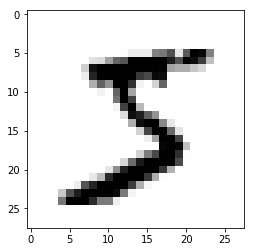

In [5]:
timg, c = train_dataset[0]
print(timg.shape, c)
plt.imshow(timg.squeeze(0), cmap='gray_r')

In [6]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./torch_datasets
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

torch.Size([1, 28, 28]) 7


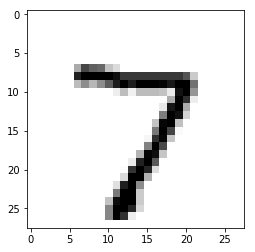

In [7]:
timg, c = test_dataset[0]
print(timg.shape, c)
plt.imshow(timg.squeeze(0), cmap='gray_r')

# DataLoader

We will now define the size of the batch we want to use. And we will create a dataloader that will allow us to get data from the dataset by batch of the given size (this will be easier than creating a loop ourselves).

In [8]:
batchsize = 4

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, batchsize)
test_loader = torch.utils.data.DataLoader(test_dataset, batchsize)

# PYNQ Overlay

We will load the PYNQ overlay, and define handler for the AXI GPIO and DMA that are present in this overlay.

In [10]:
from pynq import Overlay
from pynq import allocate
import pynq.lib.dma

In [11]:
# Load the overlay
overlay = Overlay("/home/xilinx/pynq/overlays/multaccum/multaccum.bit")

In [12]:
# Load the AXI GPIO and DMAs
axigpio_size = overlay.multaccum.din_size
dma_in_a = overlay.multaccum.in_a_dma
dma_in_b = overlay.multaccum.in_b_dma
dma_out = overlay.multaccum.out_dma

The DMAs require contiguous memory buffer. Let's allocate them.

In [13]:
n = 2**21
in_a_buffer = allocate(shape=(n,), dtype=np.float32)
in_b_buffer = allocate(shape=(n,), dtype=np.float32)

out_buffer = allocate(shape=(2**16,), dtype=np.float32)

# Overlay driver function

We will now define the 'multaccumx' function that will use the FPGA to perform the following computation :

    output = inputs @ weights.t() + bias

In [14]:
def multaccumx(inputs, weights, bias):

    # Check that the arguments are corretly shaped
    if inputs.dim() != 2:
        print("ERROR : 'inputs' dim is not 2 !", inputs.dim())
        print(inputs.shape)
        return 0
    if weights.dim() != 2:
        print("ERROR : 'weights' dim is not 2 !", weights.dim())
        return 0
    if bias.dim() != 1:
        print("ERROR : 'bias' dim is not 1 !", bias.dim())
        return 0

    # Store the sizes
    nb_din, sz_din = inputs.shape
    nb_neuron, sz_neuron = weights.shape
    sz_bias = bias.shape[0]

    # Check that the size match
    if sz_din != sz_neuron:
        print("ERROR : 'inputs' and 'weights' size is not equal !", sz_din, sz_neuron)
        return 0
    if nb_neuron != sz_bias:
        print("ERROR : 'weights' and 'bias' size is not equal !", nb_neuron, sz_bias)
        return 0

    # Configure the 'multaccum' FPGA IP with din size minus 1
    # (this is used in the IP to generate internal AXI Stream tlast) 
    axigpio_size.register_map.GPIO_DATA = sz_din-1    

    # Store the weigths in the continuous buffer that will be transfered by the DMA
    in_b_buffer[:nb_neuron*sz_neuron] = weights.flatten()

    # Loop on all din
    for i in range(nb_din):

        # Store the inputs data in the continuous buffer that will be transfered by the DMA
        # (the inputs data are repetaed as many times as the number of neuron in the layer)
        in_a_buffer[:nb_neuron*sz_din] = inputs[i].unsqueeze(0).expand(nb_neuron, -1).flatten()

        # Launch the DMA transferts
        dma_out.recvchannel.transfer(out_buffer[i*nb_neuron:])
        dma_in_b.sendchannel.transfer(in_b_buffer[:nb_neuron*sz_neuron])
        dma_in_a.sendchannel.transfer(in_a_buffer[:nb_neuron*sz_din])

        # Wait the end of result reception
        dma_out.recvchannel.wait()

    # Copy the result from the continuous buffer as a tensor of the correct shape
    dout = torch.tensor(out_buffer[:nb_din*nb_neuron]).view(nb_din, nb_neuron) + bias
    return dout


# Custom autograd function

The 'multaccumx' function is just performing a computation.

To be able to use it in a layer of a neural network, we need to wrap it to associate the corresponding gradient computation that will be required during the backward pass of the training.

In [15]:
class MyLinx(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input, weight, bias=None):
        """
        In the forward pass we receive a context object and a Tensor containing the
        input; we must return a Tensor containing the output, and we can use the
        context object to cache objects for use in the backward pass.
        """
        ctx.save_for_backward(input, weight, bias)
        output = multaccumx(input, weight, bias)
        #  if bias is not None:
        #      output += bias.unsqueeze(0).expand_as(output)
        return output

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive the context object and a Tensor containing
        the gradient of the loss with respect to the output produced during the
        forward pass. We can retrieve cached data from the context object, and must
        compute and return the gradient of the loss with respect to the input to the
        forward function.
        """
        input, weight, bias = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = None

        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0).squeeze(0)

        return grad_input, grad_weight, grad_bias


mylinx = MyLinx.apply


# Custom nn.Linear

PyTorch contains object that can easily be used to build a neural network.

We don't want to recreate completely such an object, as we just want to change
the way the forward computation of a linear layer is computed (to use the FPGA to compute it).

We can do this by simply overiding the forward part of the existing 'nn.Linear' object.

In [16]:
class myLinearX(nn.Linear):
        
    def forward(self, input):
        #output = input @ self.weight.t() + self.bias
        output = mylinx(input.flatten(1), self.weight, self.bias)
        return output

# Neural Network Model

We have now all the pieces we needed. We can define the neural network model we want, and use our new 'myLinearX' linear layer in it.

In [17]:
mymodelx = nn.Sequential(
    nn.Flatten(),
    myLinearX(784,128),
    nn.ReLU(),
    myLinearX(128,32),
    nn.ReLU(),
    myLinearX(32, 10),
    nn.LogSoftmax(dim=1)
)

This model defines :
* the architecture of the network,
* the parameters of the network,
* the initilization of these parameters,
* and the gradient that will be computed.

We also need to define the way we will upgrade the parameters with the computed gradient, and the associated learning rate. 

In [18]:
myoptimizerx = torch.optim.SGD(mymodelx.parameters(), lr=1e-3)

# Training time

To train our network we need to :
* reinitialize all the gradients to 0
* perform a forward pass on a batch of data to compute the output of the model
* compute a loss to evaluate how far our output is from the required output
* use the computed loss to perform the backward pass that will define all the gradients
* update the parameters with the computed gradient as defined in our optimizer
* repeat until the end of the train dataset

We will gather all theses steps in a 'train' function.

In [19]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

We need to evaluate how good our training is.

For this, the output of the model is used to perform a prediction that is supposed to match with the target output. We will use the test dataset to check how many time the prediciotn is correct for data our model have not used for its training.

As this is for evaluation only, we will only perform the forward pass, and no gradient computation will be required.

Let's define a 'test' fucntion that will perform this evaluation on the test dataset.

In [23]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            if batch_idx % 1000 == 0:
                print("Test batch index:", batch_idx)

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

We can now launch the training. As this training is slow, we will do only one epoch.

In [21]:
for epoch in range(1):
    train(mymodelx, train_loader, myoptimizerx, epoch)
    test(mymodelx, test_loader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.406540
Train Epoch: 0 [4000/60000 (7%)]	Loss: 1.743816
Train Epoch: 0 [8000/60000 (13%)]	Loss: 0.602789
Train Epoch: 0 [12000/60000 (20%)]	Loss: 0.708294
Train Epoch: 0 [16000/60000 (27%)]	Loss: 0.649807
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.687648
Train Epoch: 0 [24000/60000 (40%)]	Loss: 0.352677
Train Epoch: 0 [28000/60000 (47%)]	Loss: 0.047605
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.208460
Train Epoch: 0 [36000/60000 (60%)]	Loss: 0.310835
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.026316
Train Epoch: 0 [44000/60000 (73%)]	Loss: 0.335622
Train Epoch: 0 [48000/60000 (80%)]	Loss: 0.087380
Train Epoch: 0 [52000/60000 (87%)]	Loss: 0.023506
Train Epoch: 0 [56000/60000 (93%)]	Loss: 0.228996


NameError: name 'device' is not defined

In [24]:
test(mymodelx, test_loader)

Test batch index: 0
Test batch index: 1000
Test batch index: 2000

Test set: Average loss: 0.3096, Accuracy: 9058/10000 (90.58%)

